<a href="https://colab.research.google.com/github/vanecornejo/Simulaci-n-I/blob/main/Inventario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejemplo 5.5 Sistema de inventarios**

La demanda mensual de cierto producto sigue la siguiente distribución de probabilidad empírica:

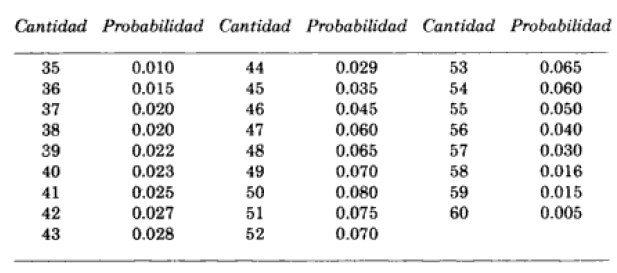

El tiempo de entrega está distribuido de acuerdo a la siguiente función de probabilidad:

**Meses &ensp; &emsp; &emsp; &emsp; 1 &emsp; &emsp; 2 &emsp; &emsp; 3**

**Probabilidad &emsp; 0.30 &ensp; 0.40 &ensp; 0.30**

Los factores estacionales para cada uno de los meses del año son como se muestra a continuación:

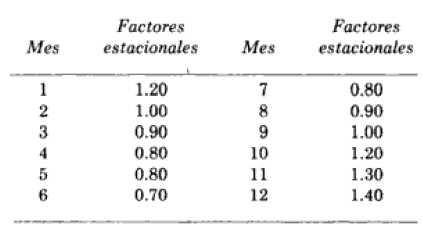

La información con respecto a los costos relevantes es la siguiente:

- Costo de ordenar = 120/orden
- Costo de inventario = 20/unidad/año
- Costo de faltante = 50/unidad

Si el inventario inicial se asume en 150 unidades, ¿determine la cantidad óptima a ordenar (q) y el nivel óptimo de reorden (R)?

## *Solución al problema*
Se usa el Método de la Transformada Inversa para simular la demanda del mes y el tiempo de entrega de una orden, se genera un numero aleatorio y si cae dentro de un intervalo generado por la probabilidad se suman acumulativamente las probabilidades para obtener estos intervalos.

In [127]:
# importamos librerías
import random
import pandas as pd
from tabulate import tabulate

In [128]:
random.seed(42) # para reproducibilidad

# Ingresamos los datos que nos da el problema
cantidades = [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]

probabilidades = [0.010, 0.015, 0.020, 0.020, 0.022, 0.023, 0.025, 0.027, 0.028, 0.029, 0.035, 0.045, 0.060,
                  0.065, 0.070, 0.080, 0.075, 0.070, 0.065, 0.060, 0.050, 0.040, 0.030, 0.016, 0.015, 0.005]

tiempos_entrega = [1, 2, 3]
prob_tiempos = [0.3, 0.4, 0.3]

factores_estacionales = [1.20, 1.00, 0.90, 0.80, 0.80, 0.70, 0.80, 0.90, 1.00, 1.20, 1.30, 1.40]

costo_orden = 100
costo_inventario_anual = 20
costo_faltante = 50

Definimos la función donde haremos la simulación del comportamiento del sistema mes a mes por 12 meses para un inventario inicial de 150.

Si el inventario disponible es menor o igual a R y no hay pedidos pendientes, realizar un pedido de q unidades.

In [129]:
def simular(q, R, inventario_inicial=150, meses=12, imprimir_tabla=True):
    inventario = inventario_inicial
    pedidos_pendientes = [] # creamos una lista para guardar los pedidos pendientes

    # Inicializamos
    total_orden = 0
    total_inventario = 0
    total_faltante = 0

    # Listas para la tabla
    tabla = {
        "Mes": [],
        "Inventario Inicial": [],
        "Número Aleatorio": [],
        "Demanda Ajustada": [],
        "Inventario Final": [],
        "Faltante": [],
        "Orden": [],
        "Inventario Mensual Promedio": []
    }

    for mes in range(meses):
        inv_ini = inventario
        pedido_realizado = "No"

        # Revisar si llega algún pedido
        nuevos_pedidos = []
        for llegada, cantidad in pedidos_pendientes:
            if llegada == mes:
                inventario += cantidad
            else:
                nuevos_pedidos.append((llegada, cantidad))
        pedidos_pendientes = nuevos_pedidos

        # Generar número aleatorio y demanda ajustada
        u = random.random()
        demanda_base = random.choices(cantidades, weights=probabilidades, k=1)[0]
        demanda_ajustada = round(demanda_base * factores_estacionales[mes])

        # Faltantes
        if demanda_ajustada > inventario:
            faltante = demanda_ajustada - inventario
            inventario = 0
        else:
            faltante = 0
            inventario -= demanda_ajustada

        # Costos
        total_faltante += faltante * costo_faltante
        total_inventario += inventario * (costo_inventario_anual / 12)

        # Pedido si es necesario
        if inventario <= R and not pedidos_pendientes:
            tiempo = random.choices(tiempos_entrega, weights=prob_tiempos, k=1)[0]
            llegada = mes + tiempo
            if llegada < meses:
                pedidos_pendientes.append((llegada, q))
            total_orden += costo_orden
            pedido_realizado = "Sí"

        # Guardamos los datos calculados en la tabla
        tabla["Mes"].append(mes + 1)
        tabla["Inventario Inicial"].append(inv_ini)
        tabla["Número Aleatorio"].append(round(u, 4))
        tabla["Demanda Ajustada"].append(demanda_ajustada)
        tabla["Inventario Final"].append(inventario)
        tabla["Faltante"].append(faltante)
        tabla["Orden"].append(pedido_realizado)
        tabla["Inventario Mensual Promedio"].append(round((inv_ini + inventario) / 2, 2))

    # Creamos un DataFrame
    df = pd.DataFrame(tabla)

    # Costos
    costo_total = total_orden + total_inventario + total_faltante

    if imprimir_tabla:
      print(f"\n>>> Mejor combinación: q = {q}, R = {R}\n")
      print(tabulate(df, headers='keys', tablefmt='psql'))

      print(f"  Costo de ordenar:     ${total_orden:.2f}")
      print(f"  Costo de inventario:  ${total_inventario:.2f}")
      print(f"  Costo de faltante:    ${total_faltante:.2f}")
      print(f"  Costo total anual:    ${costo_total:.2f}")

    return costo_total, df, total_orden, total_inventario, total_faltante

Definimos una función para buscar los valores óptimos de q y R que haga distintas combinaciones de estos y seleccionar la combinación con menor costo total anual.


In [130]:
def buscar_optimo(valores_q, valores_R):
    mejor_costo = float('inf')
    mejor_q = mejor_R = None
    mejor_df = None
    mejor_costos = ()

    for q in valores_q:
        for R in valores_R:
            costo, df, orden, inventario, faltante = simular(q, R, imprimir_tabla=False)
            if costo < mejor_costo:
                mejor_costo = costo
                mejor_q = q
                mejor_R = R
                mejor_df = df
                mejor_costos = (orden, inventario, faltante)

    # Imprimimos para el óptimo
    simular(mejor_q, mejor_R, imprimir_tabla=True)

valores_q = [100, 150, 200, 250]
valores_R = [50, 75, 100, 125]

buscar_optimo(valores_q, valores_R)


>>> Mejor combinación: q = 150, R = 75

+----+-------+----------------------+--------------------+--------------------+--------------------+------------+---------+-------------------------------+
|    |   Mes |   Inventario Inicial |   Número Aleatorio |   Demanda Ajustada |   Inventario Final |   Faltante | Orden   |   Inventario Mensual Promedio |
|----+-------+----------------------+--------------------+--------------------+--------------------+------------+---------+-------------------------------|
|  0 |     1 |                  150 |             0.7193 |                 60 |                 90 |          0 | No      |                         120   |
|  1 |     2 |                   90 |             0.8306 |                 50 |                 40 |          0 | Sí      |                          65   |
|  2 |     3 |                   40 |             0.7437 |                 44 |                  0 |          4 | No      |                          20   |
|  3 |     4 |         